In [376]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.stats import mode
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 1. Supervised, Semi-Supervised, and Unsupervised Learning

## b) Monte-Carlo Simulation
For each method, I will be repeating the procedure 30 times and use randomly selected train and test data

### i. Supervised Learning (L1-Penalized SVM)

In [459]:
def print_metrics(y, pred, pred_prob, roc):
    accuracy = skm.accuracy_score(y, pred)
    precision = skm.precision_score(y, pred)
    recall = skm.recall_score(y, pred)
    f1 = skm.f1_score(y, pred)
    
    fpr, tpr, _ = skm.roc_curve(y, pred_prob)
    
    if roc:
        print("Confusion Matrix: ")
        print(skm.confusion_matrix(y, pred))
        
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([-0.02, 1.0])
        plt.ylim([0.0, 1.02])
        plt.title("ROC Curve")
        plt.show()
        
    auc = skm.auc(fpr, tpr)
    
    return [accuracy, precision, recall, f1, auc]
    
    
def svm_l1(c, train_X, test_X, train_y, test_y, roc):
    metrics = []
    svm_l1 = LinearSVC(C=c, max_iter=1000, penalty='l1', dual=False)
    svm_l1.fit(train_X, train_y)
    
    predict_test = svm_l1.predict(test_X)
    predict_train = svm_l1.predict(train_X)
    predict_prob_test = svm_l1.decision_function(test_X)
    predict_prob_train = svm_l1.decision_function(train_X)
    
    if roc:
        print("Test ROC + Confusion Matrix")
    test_metrics = print_metrics(test_y, predict_test, predict_prob_test, roc)
    if roc:
        print("Train ROC + Confusion Matrix")
    train_metrics = print_metrics(train_y, predict_train, predict_prob_train, roc)
    
    return test_metrics, train_metrics
    
    
def svm_l1_cv(params, train_X, trainy):
    pipe = Pipeline([('scaler', StandardScaler()), 
                         ('svc', LinearSVC(max_iter=1000, penalty='l1', dual=False))])
    svm_l1_cv = GridSearchCV(estimator=pipe, param_grid=params, n_jobs=-1, cv=5)
    svm_l1_cv.fit(train_X, trainy)
    
    # Extract ideal parameters from cross-validation
    ideal_C = svm_l1_cv.best_params_['svc__C']
    
    return ideal_C

In [429]:
df = pd.read_table('../data/wdbc.data', sep=',', header=None).iloc[:, 1:]
X = df.iloc[:, 1:]
y = df.iloc[:, 0].replace({'M': 1, 'B': 0}) # we convert malignant to 1 (meaning positive) and 0 otherwise

#### We execute the SVM learner once to tune the lower and upper bounds for lambda, and also to display the ROC Curve and confusion matrix

In [439]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

I am only normalizing to pass through the tuned model. Notice how, in the cross-validation function, I pipelined th StandardScaler() to normalize each fold

In [440]:
standardize = StandardScaler()
train_X_std = standardize.fit_transform(train_X)
test_X_std = standardize.fit_transform(test_X)

Deciding the upper and lower bounds for lambda

In [441]:
lamb_lb = 1e-3
lamb_ub = 1e6

print("lb")
svm_l1(1/lamb_lb, train_X_std, test_X_std, train_y, test_y, False)

print("ub")
svm_l1(1/lamb_ub, train_X_std, test_X_std, train_y, test_y, False)

lb
ub


([0.631578947368421, 0.0, 0.0, 0.0, 0.5],
 [0.6263736263736264, 0.0, 0.0, 0.0, 0.5])

Test ROC + Confusion Matrix
Confusion Matrix: 
[[70  2]
 [ 4 38]]


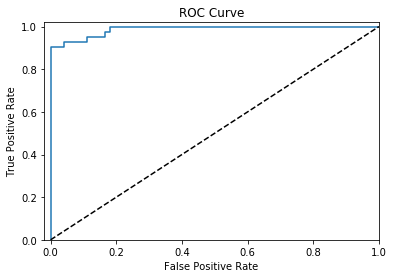

Train ROC + Confusion Matrix
Confusion Matrix: 
[[285   0]
 [  3 167]]


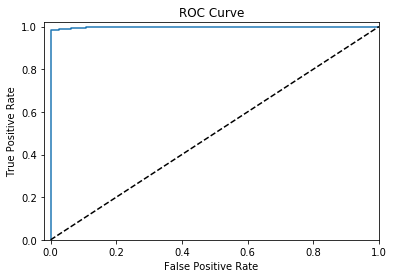

In [442]:
params = {"svc__C": 1/np.logspace(-3, 6, 20)}

ideal_C = svm_l1_cv(params, train_X, train_y)
test_metrics, train_metrics = svm_l1(ideal_C, train_X_std, test_X_std, train_y, test_y, True)

#### Do the same process 29 more times, then find the average

In [443]:
test_list = [test_metrics]
train_list = [train_metrics]
for i in range(29):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)
    standardize = StandardScaler()
    train_X_std = standardize.fit_transform(train_X)
    test_X_std = standardize.fit_transform(test_X)

    ideal_C = svm_l1_cv(params, train_X, train_y)
    test, train = svm_l1(ideal_C, train_X_std, test_X_std, train_y, test_y, False)
    test_list.append(test)
    train_list.append(train)

In [444]:
summary_test = pd.DataFrame(test_list, columns =['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
print("Test Set Summary: ")
print(summary_test.mean())

summary_train = pd.DataFrame(train_list, columns =['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
print("\nTrain Set Summary: ")
print(summary_train.mean())

Test Set Summary: 
Accuracy     0.957895
Precision    0.944882
Recall       0.942063
F1           0.942925
AUC          0.987302
dtype: float64

Train Set Summary: 
Accuracy     0.991502
Precision    0.995044
Recall       0.982157
F1           0.988547
AUC          0.999044
dtype: float64


## ii. Semi-Supervised/Self-Training

1. Start with 50% of positive and negative class as labeled data. The rest are unlabeled.
2. Train the labelled data with L1 penalized SVM using 5-fold CV
3. Pick the unlabeled data point that is farthest to the decision boundary
    a) Label it, then train the SVM again with that datapoint
    b) Repeat 3 until all the unlabelled data is classified
4. Train the final SVM and print the same metrics

#### We start, again, by doing this process once. We also display the ROC and Confusion matrix for this run

In [445]:
def svm_l1_selftrain(c, train_X, unlabeled_X, train_y):
    svm_l1 = LinearSVC(C=c, max_iter=1000, penalty='l1', dual=False)
    svm_l1.fit(train_X, train_y)
    predict_prob = svm_l1.decision_function(unlabeled_X)
    #w_norm = np.linalg.norm(svm_l1.coef_)
    #dist = predict_prob/w_norm

    predict = svm_l1.predict(unlabeled_X)

    farthest = np.argmax(np.absolute(predict_prob))
    
    return farthest, predict[farthest]

Before everything, I'm roughly narrowing the bounds to cross-validate with

In [446]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)
train_labeled_X, train_unlabeled_X, train_labeled_y, train_unlabeled_y = train_test_split(train_X, 
                                                train_y, test_size = 0.5, random_state=3, stratify=train_y)

train_unlabeled_X = train_unlabeled_X.reset_index().drop(columns=['index'])
train_labeled_X = train_labeled_X.reset_index().drop(columns=['index'])
train_labeled_y = list(train_labeled_y.ravel())

In [447]:
standardize = StandardScaler()
train_X_std = standardize.fit_transform(train_labeled_X)
test_X_std = standardize.fit_transform(test_X)

In [448]:
lamb_lb = 1e-4
lamb_ub = 1e6

print("lb")
svm_l1(1/lamb_lb, train_X_std, test_X_std, train_labeled_y, test_y, False)

print("ub")
svm_l1(1/lamb_ub, train_X_std, test_X_std, train_labeled_y, test_y, False)

lb
ub


([0.631578947368421, 0.0, 0.0, 0.0, 0.5],
 [0.6255506607929515, 0.0, 0.0, 0.0, 0.5])

#### A. Train L1-Penalized SVM

In [449]:
params = {"svc__C": 1/np.logspace(-4, 6, 20)}

ideal_C = svm_l1_cv(params, train_labeled_X, train_labeled_y)

#### B. Constantly Retrain SVM by Including One Unlabeled Datapoint to Labeled

Test ROC + Confusion Matrix
Confusion Matrix: 
[[66  6]
 [ 4 38]]


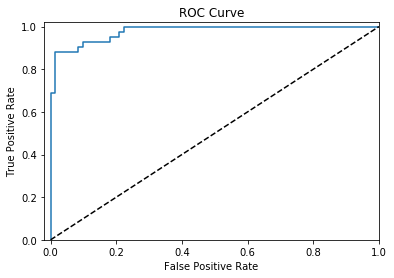

Train ROC + Confusion Matrix
Confusion Matrix: 
[[291   0]
 [  0 164]]


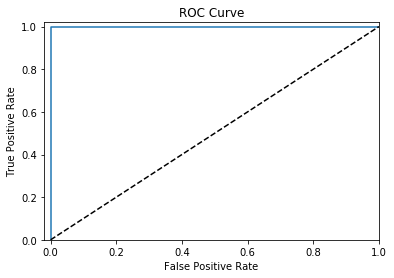

In [450]:
train_X_std = standardize.fit_transform(train_labeled_X)
train_unlabeled_X_std = standardize.fit_transform(train_unlabeled_X)

while len(train_unlabeled_X_std) > 0:
    # Find the farthest point of the SVM and its predicted label
    farthest, label = svm_l1_selftrain(ideal_C, train_X_std, train_unlabeled_X_std, train_labeled_y)
    
    # Isolate row from the unlabeled set
    buffer_row = train_unlabeled_X_std[farthest]
    train_unlabeled_X_std = np.delete(train_unlabeled_X_std, farthest, axis=0)

    # add the row to labeled set
    train_X_std = np.append(train_X_std, [buffer_row], axis=0)
    train_labeled_y.append(label)

# finally, train the last one
#ideal_C = svm_l1_cv(params, train_labeled_X, train_labeled_y)
#train_X_std = standardize.fit_transform(train_labeled_X)
test_metrics, train_metrics = svm_l1(ideal_C, train_X_std, test_X_std, train_labeled_y, test_y, True)

#### Repeat 29 more times, then take the mean

In [451]:
params = {"svc__C": 1/np.logspace(-4, 6, 20)}
test_list = [test_metrics]
train_list = [train_metrics]
for i in range(29):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)
    train_labeled_X, train_unlabeled_X, train_labeled_y, train_unlabeled_y = train_test_split(train_X, 
                                                    train_y, test_size = 0.5, stratify=train_y)

    train_unlabeled_X = train_unlabeled_X.reset_index().drop(columns=['index'])
    train_labeled_X = train_labeled_X.reset_index().drop(columns=['index'])
    train_labeled_y = list(train_labeled_y.ravel())
    
    
    # --- PART A. Train an L1-Penalized SVM with CV = 5 ---
    ideal_C = svm_l1_cv(params, train_labeled_X, train_labeled_y)
    
    # Normalizing all datasets first
    test_X_std = standardize.fit_transform(test_X)  
    train_X_std = standardize.fit_transform(train_labeled_X)
    train_unlabeled_X_std = standardize.fit_transform(train_unlabeled_X)

    # --- PART B ---
    while len(train_unlabeled_X_std) > 0:
        # Find the farthest point of the SVM and its predicted label
        farthest, label = svm_l1_selftrain(ideal_C, train_X_std, train_unlabeled_X_std, train_labeled_y)

        # Isolate row from the unlabeled set
        buffer_row = train_unlabeled_X_std[farthest]
        train_unlabeled_X_std = np.delete(train_unlabeled_X_std, farthest, axis=0)

        # add the row to labeled set
        train_X_std = np.append(train_X_std, [buffer_row], axis=0)
        train_labeled_y.append(label)
    
    test, train = svm_l1(ideal_C, train_X_std, test_X_std, train_labeled_y, test_y, False)
    test_list.append(test)
    train_list.append(train)

In [452]:
summary_test_b = pd.DataFrame(test_list, columns =['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
print("Test Set Summary: ")
print(summary_test_b.mean())

summary_train_b = pd.DataFrame(train_list, columns =['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
print("\nTrain Set Summary: ")
print(summary_train_b.mean())

Test Set Summary: 
Accuracy     0.954971
Precision    0.936753
Recall       0.945238
F1           0.939982
AUC          0.988183
dtype: float64

Train Set Summary: 
Accuracy     0.997363
Precision    0.999401
Recall       0.993467
F1           0.996413
AUC          0.999765
dtype: float64


### iii. Unsupervised Learning (K-Means)
We assume that k = 2 instead of looking at the labels of the data

#### We first run the KMeans algorithm once, and display ROC & Confusion Matrix
#### A) 
- Run k-means multiple times to make sure that the algorithm is not trapped in a local minimum

**How to avoid local minima**: Notice that I iterated KMeans 1,000 times, and initialized the points randomly (as opposed to using kmeans++). I'm doing this in order to minimize the chances that my algorithm is trapped in a local minimum. Of course, there is no guarantee, but repeating it 1,000 times may be sufficient to find the optimal solution

In [454]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
train_X = train_X.reset_index().drop(columns=['index'])
train_y = train_y.reset_index().drop(columns=['index'])
test_X = test_X.reset_index().drop(columns=['index'])

train_X_std = standardize.fit_transform(train_X)
test_X_std = standardize.fit_transform(test_X)
km = KMeans(n_clusters=2, init='random', n_init=1000).fit(train_X_std)

#### B)
- Find centers of the 2 clusters and find closest 30 data points to each other.
- Find true labels of those 30 data points and take majority poll. That poll becomes the label predicted by kmeans of each cluster

**Note on ROC and AUC**: I passed the distances of the data point to the cluster center through a softmax function to calculate probabilities. While this is a proxy, it might not be the best point of reference to compare with other methods

Confusion Matrix: 
[[277   8]
 [ 33 137]]


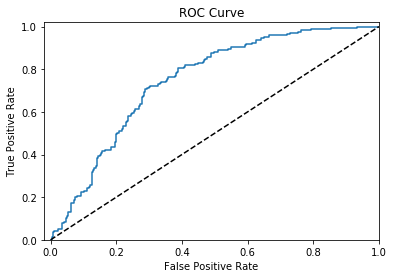

In [455]:
centers = km.cluster_centers_
pred_cluster = km.labels_
distances = cdist(train_X_std, centers, 'euclidean')
cluster1 = np.array([i[0] for i in distances])
cluster2 = np.array([i[1] for i in distances])
min_30_1 = cluster1.argsort()[:30]
min_30_2 = cluster2.argsort()[:30]
min1 = train_y.iloc[min_30_1, :].to_numpy().flatten()
min2 = train_y.iloc[min_30_2, :].to_numpy().flatten()

replace = {0: mode(min1)[0][0], 1: mode(min2)[0][0]}

pred_class = [replace[i] for i in pred_cluster]

dist = []
for i, j in enumerate(pred_cluster):
    centroid = centers[j]
    datapoint = train_X_std[i]
    dist.append(np.linalg.norm(centroid-datapoint))

probabilities = np.exp(dist) / np.sum(np.exp(dist)) # pass through a softmax function

train1 = print_metrics(train_y, pred_class, probabilities, True)

#### C) Classify Test data

Confusion Matrix: 
[[65  7]
 [ 7 35]]


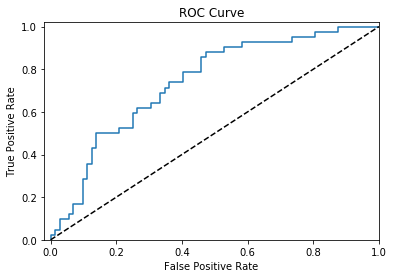

In [456]:
pred_cluster = km.predict(test_X_std)

pred_class = [replace[i] for i in pred_cluster]

## Compute distance of each datapoint to respective cluster
dist = []
for i, j in enumerate(pred_cluster):
    centroid = centers[j]
    datapoint = test_X_std[i]
    dist.append(np.linalg.norm(centroid-datapoint))

probabilities = np.exp(dist) / np.sum(np.exp(dist)) # pass through a softmax function

test1 = print_metrics(test_y, pred_class, probabilities, True)

#### Repeat the process 29 more times

In [457]:
test_list = [test1]
train_list = [train1]
for i in range(29):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)
    train_X = train_X.reset_index().drop(columns=['index'])
    train_y = train_y.reset_index().drop(columns=['index'])
    test_X = test_X.reset_index().drop(columns=['index'])

    train_X_std = standardize.fit_transform(train_X)
    test_X_std = standardize.fit_transform(test_X)
    km = KMeans(n_clusters=2, init='random', n_init=1000).fit(train_X_std, test_X_std)
    centers = km.cluster_centers_
    
    # PART B: Training Set
    pred_cluster = km.labels_
    distances = cdist(train_X_std, centers, 'euclidean')
    cluster1 = np.array([i[0] for i in distances])
    cluster2 = np.array([i[1] for i in distances])
    min_30_1 = cluster1.argsort()[:30]
    min_30_2 = cluster2.argsort()[:30]
    min1 = train_y.iloc[min_30_1, :].to_numpy().flatten()
    min2 = train_y.iloc[min_30_2, :].to_numpy().flatten()

    replace = {0: mode(min1)[0][0], 1: mode(min2)[0][0]}

    pred_class = [replace[i] for i in pred_cluster]

    ## Compute distance of each datapoint to respective cluster
    dist = []
    for i, j in enumerate(pred_cluster):
        centroid = centers[j]
        datapoint = train_X_std[i]
        dist.append(np.linalg.norm(centroid-datapoint))

    probabilities = np.exp(dist) / np.sum(np.exp(dist)) # pass through a softmax function

    train_list.append(print_metrics(train_y, pred_class, probabilities, False))
    
    # PART C: Test Set
    pred_cluster = km.predict(test_X_std)

    pred_class = [replace[i] for i in pred_cluster]

    ## Compute distance of each datapoint to respective cluster
    dist = []
    for i, j in enumerate(pred_cluster):
        centroid = centers[j]
        datapoint = test_X_std[i]
        dist.append(np.linalg.norm(centroid-datapoint))

    probabilities = np.exp(dist) / np.sum(np.exp(dist)) # pass through a softmax function

    test_list.append(print_metrics(test_y, pred_class, probabilities, False))

In [458]:
summary_test_c = pd.DataFrame(test_list, columns =['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
print("Test Set Summary: ")
print(summary_test_c.mean())

summary_train_c = pd.DataFrame(train_list, columns =['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
print("\nTrain Set Summary: ")
print(summary_train_c.mean())

Test Set Summary: 
Accuracy     0.909064
Precision    0.923591
Recall       0.822222
F1           0.869315
AUC          0.741590
dtype: float64

Train Set Summary: 
Accuracy     0.912015
Precision    0.928485
Recall       0.828824
F1           0.875640
AUC          0.737332
dtype: float64


### iv. Spectral Clustering
#### A) Run Spectral Clustring Multiple Times (Same as iii. A)
**Note on Normalization/Standardization**: I experimented with doing MinMaxScaler() and StandardScaler(), and it seems like for i-iii., StandardScaler() worked much better. However, Spectral Clustering didn't really like this scaler (it would predict all of it to class 0), so I switched to MinMaxScaler() here.

In [473]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
train_X = train_X.reset_index().drop(columns=['index'])
train_y = train_y.reset_index().drop(columns=['index'])
test_X = test_X.reset_index().drop(columns=['index'])
test_y = test_y.reset_index().drop(columns=['index'])
standardize = MinMaxScaler()
train_X_std = standardize.fit_transform(train_X)
test_X_std = standardize.fit_transform(test_X)
sc = SpectralClustering(n_clusters=2, gamma=1, affinity='rbf', n_init=1000).fit_predict(train_X_std)

#### B) Training Data
- Take majority polling to find the assigned label of each cluster

#### ASIDE: Defining ROC for Spectral Clustering
I varied the thresholds for majority polling to emulate the ROC and AUC. The following is a function that takes the labels for both clusters and plots the ROC. It returns the AUC

In [462]:
def spectral_clustering_roc(label0, label1, sc, train_y, display):
    thresholds = np.linspace(0, 100, 41)
    count0 = Counter(label0)
    count1 = Counter(label1)
    
    for i in count0:
        count0[i] /= float(len(label0)) * 0.01
    for i in count1:
        count1[i] /= float(len(label1)) * 0.01
        

    # If none of the classes reach a certain threshold, pick 0
    # If both of the classes reach a certain threshold, pick 1
    def cluster_decide(count, threshold):
        pass0 = False
        pass1 = False
        if count[0] > threshold:
            pass0 = True
        if count[1] > threshold:
            pass1 = True

        if pass0 == True and pass1 == True:
            pred = 1
        elif pass0 == False and pass1 == False:
            pred = 0
        else:
            if pass0 == True:
                pred = 0
            if pass1 == True:
                pred = 1
                
        return pred
        
    fpr = []
    tpr = []
    for threshold in thresholds:
        pred0 = cluster_decide(count0, threshold)
        pred1 = cluster_decide(count1, threshold)

        replace = {0: pred0, 1: pred1}
        pred_class = np.array([replace[i] for i in sc])
        
        tn, fp, fn, tp = skm.confusion_matrix(train_y, pred_class, labels=[0,1]).ravel()
        tpr.append(float(tp)/float(tp+fn))
        fpr.append(float(fp)/float(fp+tn))
        
    
    # --- ROC PLOT ---
    if display:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([-0.02, 1.0])
        plt.ylim([0.0, 1.02])
        plt.title("ROC Curve")
        plt.show()

    # --- AUC ---
    return skm.auc(fpr, tpr)

In [463]:
def print_metrics_iv(y, pred):
    accuracy = skm.accuracy_score(y, pred)
    precision = skm.precision_score(y, pred)
    recall = skm.recall_score(y, pred)
    f1 = skm.f1_score(y, pred)
    
    return [accuracy, precision, recall, f1]

Confusion Matrix: 
[[283   2]
 [ 78  92]]


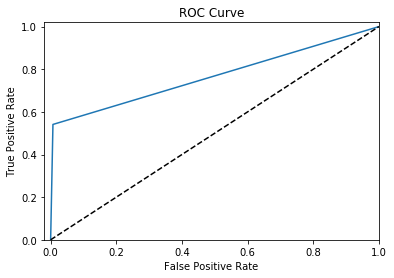

In [475]:
cluster0 = [i for i, x in enumerate(sc) if x == 0]
cluster1 = [i for i, x in enumerate(sc) if x == 1]
#cluster0_30 = np.random.choice(cluster0, 30, replace=False)
#cluster1_30 = np.random.choice(cluster1, 30, replace=False)

# Find out label of both clusters
label0 = train_y.iloc[cluster0, :].to_numpy().flatten()
label1 = train_y.iloc[cluster1, :].to_numpy().flatten()

# {Cluster: Assigned Label}
replace = {0: mode(label0)[0][0], 1: mode(label1)[0][0]}
pred_class = [replace[i] for i in sc]
print("Confusion Matrix: ")
print(skm.confusion_matrix(train_y, pred_class))

auc = spectral_clustering_roc(label0, label1, sc, train_y, True)

train_metrics = print_metrics_iv(train_y, pred_class)
train_metrics.append(auc)

#### C. Test Data
The sklearn implementation of spectral clustering doesn't have a predict function, so we have to use a proxy. I implemented a 1NN and used that to predict the test data

Confusion Matrix: 
[[72  0]
 [ 6 36]]


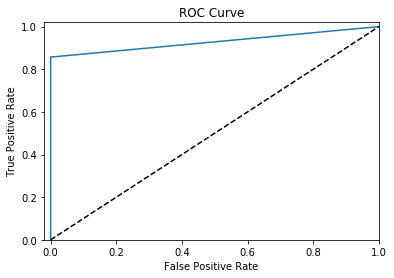

In [476]:
knn = KNeighborsClassifier(n_neighbors=1).fit(train_X_std, sc)

# -- Predict the cluster of the test_X sing 1NN as a proxy --
predict_cluster = knn.predict(test_X_std)

cluster0 = [i for i, x in enumerate(predict_cluster) if x == 0]
cluster1 = [i for i, x in enumerate(predict_cluster) if x == 1]

# Find out label of both clusters
label0 = test_y.iloc[cluster0, :].to_numpy().flatten()
label1 = test_y.iloc[cluster1, :].to_numpy().flatten()

# {Cluster: Assigned Label}
replace = {0: mode(label0)[0][0], 1: mode(label1)[0][0]}

predict_class = [replace[i] for i in predict_cluster]
print("Confusion Matrix: ")
print(skm.confusion_matrix(test_y, predict_class))

auc = spectral_clustering_roc(label0, label1, predict_cluster, test_y, True)

test_metrics = print_metrics_iv(test_y, predict_class)
test_metrics.append(auc)

#### Repeat 29 Times, then take the average

In [218]:
test_list = [test_metrics]
train_list = [train_metrics]
for i in range(29):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)
    train_X = train_X.reset_index().drop(columns=['index'])
    train_y = train_y.reset_index().drop(columns=['index'])
    test_X = test_X.reset_index().drop(columns=['index'])
    test_y = test_y.reset_index().drop(columns=['index'])

    train_X_std = standardize.fit_transform(train_X)
    test_X_std = standardize.fit_transform(test_X)
    sc = SpectralClustering(n_clusters=2, gamma=1, affinity='rbf', n_init=1000).fit_predict(train_X_std)
    
    # --- B) Training Data ---
    cluster0 = [i for i, x in enumerate(sc) if x == 0]
    cluster1 = [i for i, x in enumerate(sc) if x == 1]

    # Find out label of both clusters
    label0 = train_y.iloc[cluster0, :].to_numpy().flatten()
    label1 = train_y.iloc[cluster1, :].to_numpy().flatten()

    # {Cluster: Assigned Label}
    replace = {0: mode(label0)[0][0], 1: mode(label1)[0][0]}
    
    # Class associated with each cluster
    pred_class = [replace[i] for i in sc]
    
    # Find ROC and AUC by making the threshold of majority polling different
    auc = spectral_clustering_roc(label0, label1, sc, train_y, False)

    # Get all the metrics
    train = print_metrics_iv(train_y, pred_class)
    train.append(auc)
    
    train_list.append(train)
    
    
    # ---- C) TEST DATA ----
    knn = KNeighborsClassifier(n_neighbors=1).fit(train_X_std, sc)

    # -- Predict the cluster of the test_X using 1NN as a proxy --
    predict_cluster = knn.predict(test_X_std)

    cluster0 = [i for i, x in enumerate(predict_cluster) if x == 0]
    cluster1 = [i for i, x in enumerate(predict_cluster) if x == 1]

    # Find out label of both clusters
    label0 = test_y.iloc[cluster0, :].to_numpy().flatten()
    label1 = test_y.iloc[cluster1, :].to_numpy().flatten()

    # {Cluster: Assigned Label}
    replace = {0: mode(label0)[0][0], 1: mode(label1)[0][0]}

    predict_class = [replace[i] for i in predict_cluster]
    
    auc = spectral_clustering_roc(label0, label1, predict_cluster, test_y, False)

    test = print_metrics_iv(test_y, predict_class)
    test.append(auc)
    
    test_list.append(test)

In [223]:
summary_test_d = pd.DataFrame(test_list, columns =['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
print("Test Set Summary: ")
print(summary_test_d.mean())

summary_train_d = pd.DataFrame(train_list, columns =['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
print("\nTrain Set Summary: ")
print(summary_train_d.mean())

Test Set Summary: 
Accuracy     0.913450
Precision    0.952067
Recall       0.807143
F1           0.871587
AUC          0.891303
dtype: float64

Train Set Summary: 
Accuracy     0.857949
Precision    0.981093
Recall       0.632157
F1           0.767736
AUC          0.812394
dtype: float64


## v. Comparison of All Methods

**Analysis**: Based on the results, it seems like supervised learning and semi-supervised learning performed equally as well. (Look at the Recall and AUC of test data in particular.) Meanwhile, both unsupervised learning methods performed worse, but not by much. This is expected behavior, although it is strange that in the summary, semi-supervised learning does slightly better on average on the training data (notice that on the test data, supervised learning is best). I believe this is simply random error that not appear if we did more simulations (M->infinity), but it might also be that the error is so small that it's negligible.

In [477]:
#summary_test_b = summary_test_b.rename(columns={'Accuray': 'Accuracy'})
#summary_test_c = summary_test_c.rename(columns={'Accuray': 'Accuracy'})
train_mean = summary_train.mean().to_frame().T
train_mean = train_mean.append(summary_train_b.mean().to_frame().T, ignore_index=True).append(
    summary_train_c.mean().to_frame().T, ignore_index=True).append(
    summary_train_d.mean().to_frame().T, ignore_index=True)
train_mean = train_mean.rename({0: 'Supervised Learning', 1: 'Semi-Supervised Learning',
                               2: 'Unsupervised (k-means)', 3: 'Unsupervised (spectral clustering)'}, axis='index')

print("Summary for Training Data:")
print(train_mean)

test_mean = summary_test.mean().to_frame().T
test_mean = test_mean.append(summary_test_b.mean().to_frame().T, ignore_index=True).append(
    summary_test_c.mean().to_frame().T, ignore_index=True).append(
    summary_test_d.mean().to_frame().T, ignore_index=True)
test_mean = test_mean.rename({0: 'Supervised Learning', 1: 'Semi-Supervised Learning',
                               2: 'Unsupervised (k-means)', 3: 'Unsupervised (spectral clustering)'}, axis='index')

print("\nSummary for Test Data:")
print(test_mean)

Summary for Training Data:
                                    Accuracy  Precision    Recall        F1  \
Supervised Learning                 0.991502   0.995044  0.982157  0.988547   
Semi-Supervised Learning            0.997363   0.999401  0.993467  0.996413   
Unsupervised (k-means)              0.912015   0.928485  0.828824  0.875640   
Unsupervised (spectral clustering)  0.857949   0.981093  0.632157  0.767736   

                                         AUC  
Supervised Learning                 0.999044  
Semi-Supervised Learning            0.999765  
Unsupervised (k-means)              0.737332  
Unsupervised (spectral clustering)  0.812394  

Summary for Test Data:
                                    Accuracy  Precision    Recall        F1  \
Supervised Learning                 0.957895   0.944882  0.942063  0.942925   
Semi-Supervised Learning            0.954971   0.936753  0.945238  0.939982   
Unsupervised (k-means)              0.909064   0.923591  0.822222  0.869315   
Un

# 2. Active Learning using SVM
We are using the banknote authentication dataset (https://archive.ics.uci.edu/ml/datasets/banknote+authentication#)

## a) Split Training and Test Sets
Choose 472 data points randomly as the test set, and remaining as training

In [383]:
df1 = pd.read_table('../data/data_banknote_authentication.txt', sep=',', header=None)
X = df1.iloc[:, :4]
y = df1.iloc[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.344, stratify=y)
train_X = train_X.reset_index().drop(columns=['index'])

standardize = StandardScaler()
train_X_std = pd.DataFrame(standardize.fit_transform(train_X))

train_y = train_y.reset_index().drop(columns=['index']).to_numpy().flatten()
test_X = test_X.reset_index().drop(columns=['index'])
test_X_std = pd.DataFrame(standardize.fit_transform(test_X))
test_y = test_y.reset_index().drop(columns=['index']).to_numpy().flatten()

In [374]:
def random_order():
    class1 = [i for i, x in enumerate(train_y) if x == 1]
    class0 = [i for i, x in enumerate(train_y) if x == 0]

    initial1 = np.random.choice(class1, size=5, replace=False)
    initial0 = np.random.choice(class0, size=5, replace=False)
    initial = np.append(initial1, initial0)

    class1 = [i for i in class1 if i not in initial1]
    class0 = [i for i in class0 if i not in initial0]

    arr = np.array(class1 + class0)
    np.random.shuffle(arr)
    
    return np.append(initial, arr)

## b) Monte Carlo Simulation of Active Learning with SVMs
### i. Passive Learning with increments of 10
1. Train a SVM with a pool of 10 randomly selected data points (L1 penalty). Select penalty using CV=5
2. Repeat process with 10 extra points until you have trained with the entire training set (90 times)
    - Each time, find the test errors

In [375]:
params = {"svc__C": 1/np.logspace(-6, 6, 50)}

passive = []
for i in range(50):
    train_X_copy = train_X_std
    train_y_copy = train_y
    
    arr = random_order()
    
    max_index = 10
    test_error_list = []
    while max_index <= 900:
        temp_trainX = train_X_copy.iloc[arr[:max_index], :]
        temp_trainy = train_y_copy[arr[:max_index]]

        ideal_C = svm_l1_cv(params, temp_trainX, temp_trainy)

        svm_l1 = LinearSVC(C=ideal_C, max_iter=1000, penalty='l1', dual=False)
        svm_l1.fit(temp_trainX, temp_trainy)
        test_error_list.append(1-svm_l1.score(test_X_std, test_y))

        max_index += 10
        
    passive.append(test_error_list)

### ii. Active Learning with Increments of 10

In [384]:
params = {"svc__C": 1/np.logspace(-6, 6, 50)}

active = []
for i in range(50):
    test_error_list = []
    train_X_copy = train_X_std
    train_y_copy = train_y
    
    # The first 10 should have at least one point from each class
    new_10 = np.random.choice(900, 10, replace=False)
    check = Counter(new_10)
    while len(check) < 2:
        new_10 = np.random.choice(900, 10, replace=False)
        check = Counter(new_10)

    temp_trainX = train_X_copy.iloc[new_10, :]
    temp_trainy = train_y_copy[new_10]
    train_X_copy = train_X_copy.drop(new_10).reset_index().drop(columns=['index'])
    train_y_copy = np.delete(train_y_copy, new_10)

    while len(train_X_copy) > 0:
        ideal_C = svm_l1_cv(params, temp_trainX, temp_trainy)
        svm_l1 = LinearSVC(C=ideal_C, max_iter=1000, penalty='l1', dual=False)
        svm_l1.fit(temp_trainX, temp_trainy)
        test_error_list.append(1-svm_l1.score(test_X_std, test_y))

        # Choose 10 closest data points in training set to the hyperplane of the SVM
        distances = np.absolute(svm_l1.decision_function(train_X_copy))
        new_10 = distances.argsort()[:10]

        # Index those ones from train_X_copy
        buffer = train_X_copy.iloc[new_10, :]
        # Add to temp_trainX
        temp_trainX = temp_trainX.append(buffer, ignore_index=True)
        temp_trainy = np.append(temp_trainy, train_y_copy[new_10])

        # Delete the buffer from original data
        train_X_copy = train_X_copy.drop(new_10).reset_index().drop(columns=['index'])
        train_y_copy = np.delete(train_y_copy, new_10)

    ideal_C = svm_l1_cv(params, temp_trainX, temp_trainy)
    svm_l1 = LinearSVC(C=ideal_C, max_iter=1000, penalty='l1', dual=False)
    svm_l1.fit(temp_trainX, temp_trainy)
    test_error_list.append(1-svm_l1.score(test_X_std, test_y))
    
    active.append(test_error_list)

## c) Average Test Error vs. Pool Size
**Analysis**: As expected, the active learning method performs better than the passive learning method. This is because active learning incrementally improves by adding the datapoints closest to the hyperplane, meaning the results of the SVM will always change minutely to adjust for the points. In contrast, the passive learning method only randomly sees points.

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

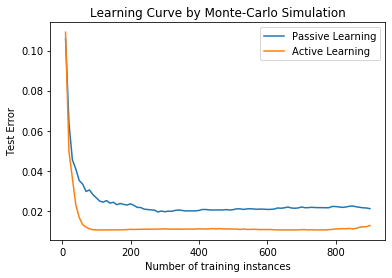

In [478]:
pool_size = np.linspace(10, 900, 90)
summary_passive = pd.DataFrame(passive).mean()
summary_active = pd.DataFrame(active).mean()

plt.plot(pool_size, summary_passive, label="Passive Learning")
plt.plot(pool_size, summary_active, label="Active Learning")
plt.title("Learning Curve by Monte-Carlo Simulation")
plt.xlabel("Number of training instances")
plt.ylabel("Test Error")
plt.legend(loc="upper right")
plt.plot